In [209]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from mpl_toolkits.axes_grid1 import ImageGrid
plt.ion()
from torch.utils.data.sampler import SubsetRandomSampler
#%matplotlib inline

In [210]:
# Data augmentation and normalization for training 
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ])    
}

In [211]:
#image_dataset Attributes:
# classes (list): List of the class names.
# class_to_idx (dict): Dict with items (class_name, class_index).
# imgs (list): List of (image path, class_index) tuples
            
#data_dir='/home/mnt/jupyter_dir/hymenoptera_data'
data_dir='/home/mnt/jupyter_dir/imagewoof'
#data_dir='/home/mnt/jupyter_dir/tiny-imagenet-200'
#data_dir='/home/mnt/jupyter_dir/stanford-cars'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), 
                        data_transforms[x]) for x in ['train', 'val'] }

image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 12454
     Root location: /home/mnt/jupyter_dir/imagewoof/train,
 'val': Dataset ImageFolder
     Number of datapoints: 500
     Root location: /home/mnt/jupyter_dir/imagewoof/val}

In [212]:
dataloaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, 
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val'] }
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [185]:
'''train_size = int(0.8 * dataset_sizes['train'])
test_size = 12454- train_size
print(train_size,test_size)
train, test = torch.utils.data.random_split(image_datasets['train'], [train_size, test_size])   
image_datasets['test']=test
image_datasets['train']=train

dataloaders_train = torch.utils.data.DataLoader(train, batch_size=16, 
                                             shuffle=True, num_workers=4)
dataloaders_test = torch.utils.data.DataLoader(test, batch_size=16, 
                                             shuffle=True, num_workers=4)
'''

"train_size = int(0.8 * dataset_sizes['train'])\ntest_size = 12454- train_size\nprint(train_size,test_size)\ntrain, test = torch.utils.data.random_split(image_datasets['train'], [train_size, test_size])   \nimage_datasets['test']=test\nimage_datasets['train']=train\n\ndataloaders_train = torch.utils.data.DataLoader(train, batch_size=16, \n                                             shuffle=True, num_workers=4)\ndataloaders_test = torch.utils.data.DataLoader(test, batch_size=16, \n                                             shuffle=True, num_workers=4)\n"

In [213]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

inputs.shape

torch.Size([16, 3, 224, 224])

In [98]:
class_names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [214]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow((inp * 255).astype(np.uint8))

torch.Size([16, 3, 224, 224]) torch.Size([16])


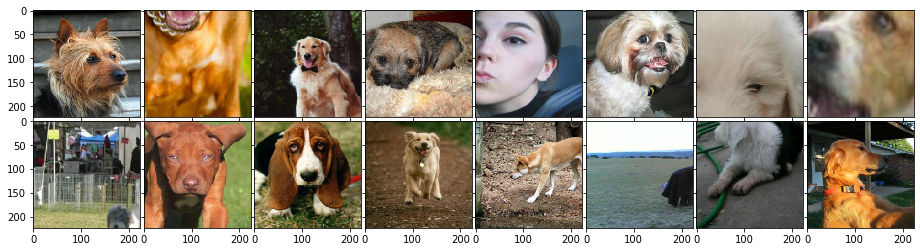

In [215]:
train = dataloaders['train']
img, label = next(iter(train))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 8), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [216]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, flag_Load=True):
    
    since= time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    
    for epoch in range(num_epochs-1):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'* 10)
        
        if flag_Load==True:
            print('Loading model from disk')
            checkpoint = torch.load('/home/mnt/jupyter_dir/saved_model/resnet101_+(epoch)+.pth.tar')
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            best_acc = checkpoint['best_prec1']
            
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            flag_load=False
            if phase == 'train':
                
                scheduler.step()
                model.train() # set model to training mode
            else:
                
                model.eval() # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                # track history if only in train
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc> best_acc:
                best_acc= epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
            print()
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'best_prec1': best_acc}, '/home/mnt/jupyter_dir/saved_model_dog/resnet101_'+str(epoch)+'.pth.tar')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))
    
    #save entire model
    torch.save(model,'/home/mnt/jupyter_dir/saved_model_dog/resnet101.pth.tar')
    
    # load best weights
    model.load_state_dict(best_model_wts)
    
    return model

In [21]:
'''
model_ft = models.resnet101(pretrained=True)
model_ft.fc
set_parameter_requires_grad(model_ft, feature_extract=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
'''

'\nmodel_ft = models.resnet101(pretrained=True)\nmodel_ft.fc\nset_parameter_requires_grad(model_ft, feature_extract=True)\nnum_ftrs = model_ft.fc.in_features\nmodel_ft.fc = nn.Linear(num_ftrs, 200)\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that all parameters are being optimized\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,                      num_epochs=25)\n'

In [217]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [218]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5, flag_Load=False)

Epoch 0/4
----------
train Loss: 0.5865 Acc: 0.8382

val Loss: 0.2277 Acc: 0.9260

Epoch 1/4
----------
train Loss: 0.3892 Acc: 0.8759

val Loss: 0.2045 Acc: 0.9200

Epoch 2/4
----------
train Loss: 0.3835 Acc: 0.8739

val Loss: 0.1633 Acc: 0.9360

Epoch 3/4
----------
train Loss: 0.3546 Acc: 0.8850

val Loss: 0.2055 Acc: 0.9280

Training complete in 8m 15s
Best val Acc : 0.936000


In [111]:
#model_conv

In [109]:
from PIL import Image
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=False)
    image = image.unsqueeze(0)
    return image

data_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
])


inputs = image_loader(data_transforms,'/home/mnt/jupyter_dir/imagenette/test1s.jpg')
print(inputs.shape)
corrects=0
model_conv.eval()
with torch.no_grad():    
    #inputs, classes = next(iter(dataloaders['val']))
    inputs = inputs.to(device)
    #classes = classes.to(device)
    logits = model_conv(inputs)
    _, pred=torch.max(logits,1)
    #corrects = torch.sum(pred==classes)

torch.Size([1, 3, 100, 100])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [107]:
pred

tensor([6], device='cuda:0')

In [108]:
logits

tensor([[-4.4188, -2.4998, -1.1672,  3.6040, -2.4621, -2.4955,  7.7907,  4.6317,
         -3.9088,  0.1829]], device='cuda:0')

In [112]:
# transformer for validation image
data_transforms2 = {
    'val':transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(100),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ])    
}

#load folders
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), 
                        data_transforms2[x]) for x in ['val'] }
print(image_datasets)

#dataloader from folders
dataloaders= {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, 
                                             shuffle=True, num_workers=0)
              for x in ['val'] }
dataset_sizes = {x: len(image_datasets[x]) for x in ['val']}
print(dataset_sizes)

{'val': Dataset ImageFolder
    Number of datapoints: 500
    Root location: /home/mnt/jupyter_dir/imagenette/val}
{'val': 500}


In [113]:
model_conv.eval()
running_loss = 0.0
running_corrects = 0
#Iterate over data
for inputs, labels in dataloaders['val']:
    print(inputs.shape)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_conv(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)
    # statistics
    running_loss += loss.item()*inputs.size(0)
    running_corrects += torch.sum(preds==labels.data)
    
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', epoch_loss, epoch_acc))

torch.Size([16, 3, 100, 100])
val Loss: 0.0004 Acc: 0.0320
torch.Size([16, 3, 100, 100])
val Loss: 0.0075 Acc: 0.0620
torch.Size([16, 3, 100, 100])
val Loss: 0.0089 Acc: 0.0940
torch.Size([16, 3, 100, 100])
val Loss: 0.0382 Acc: 0.1240
torch.Size([16, 3, 100, 100])
val Loss: 0.0433 Acc: 0.1540
torch.Size([16, 3, 100, 100])
val Loss: 0.0468 Acc: 0.1840
torch.Size([16, 3, 100, 100])
val Loss: 0.0634 Acc: 0.2120
torch.Size([16, 3, 100, 100])
val Loss: 0.0729 Acc: 0.2420
torch.Size([16, 3, 100, 100])
val Loss: 0.0816 Acc: 0.2720
torch.Size([16, 3, 100, 100])
val Loss: 0.0816 Acc: 0.3040
torch.Size([16, 3, 100, 100])
val Loss: 0.0891 Acc: 0.3340
torch.Size([16, 3, 100, 100])
val Loss: 0.1033 Acc: 0.3620
torch.Size([16, 3, 100, 100])
val Loss: 0.1205 Acc: 0.3900
torch.Size([16, 3, 100, 100])
val Loss: 0.1289 Acc: 0.4200
torch.Size([16, 3, 100, 100])
val Loss: 0.1578 Acc: 0.4460
torch.Size([16, 3, 100, 100])
val Loss: 0.1664 Acc: 0.4760
torch.Size([16, 3, 100, 100])
val Loss: 0.1664 Acc: 0.50